In [11]:
from qiskit import *
q = QuantumRegister(5,"q")
c = ClassicalRegister(5,"c")
circuit = QuantumCircuit(q,c)


circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.h(q[3])
circuit.x(q[4])
circuit.u1(-0.0706860, q[0])
circuit.u1(-0.1335178, q[1])
circuit.u1(-0.2356196, q[2])
circuit.u1(-0.3141594, q[3])
circuit.cx(q[4],q[0])
circuit.u1(0.3848452, q[0])
circuit.cx(q[4],q[1])
circuit.u1(0.6047566, q[1])
circuit.h(q[0])
circuit.cx(q[4],q[2])
circuit.u1(1.0210178, q[2])
circuit.h(q[1])
circuit.cx(q[4],q[3])
circuit.u1(1.8849556, q[3])
circuit.h(q[2])
circuit.h(q[3])
circuit.measure(q[3], c[3])
circuit.measure(q[2], c[2])
circuit.measure(q[1], c[1])
circuit.measure(q[0], c[0])
circuit.measure(q[4], c[4])

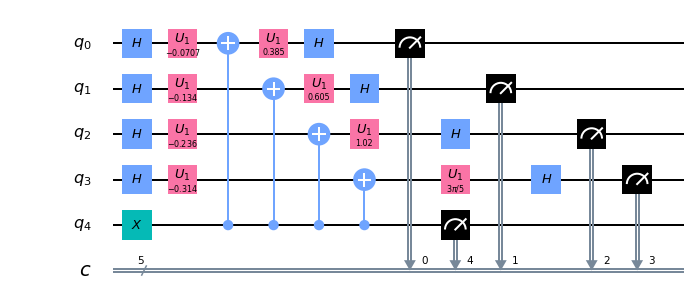

In [12]:
circuit.draw(output='mpl')

## Desired Results in Simulator

In [15]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator).result()

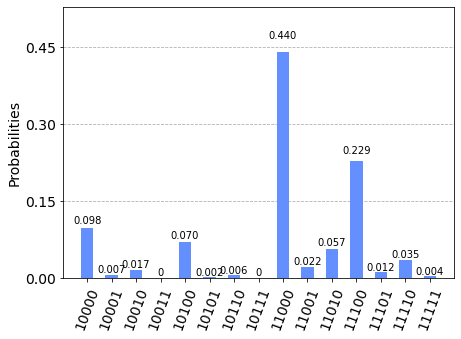

In [16]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

## Actual Results from Hardware

In [17]:
IBMQ.load_account()
provider= IBMQ.get_provider()
provider.backends()

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [18]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_essex')
job = execute(circuit,backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [19]:
result = job.result()

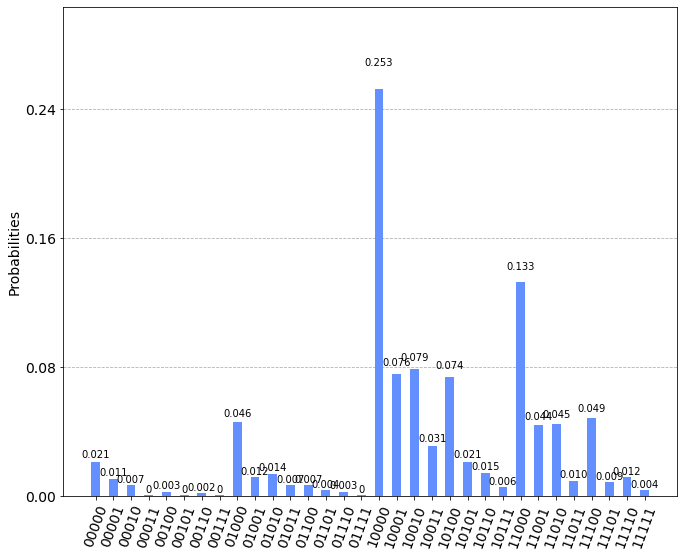

In [20]:
plot_histogram(result.get_counts(circuit), figsize=(11, 9))

## Make Filters for each possible state, in this case 2^5 = 32 states

In [21]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [27]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

Job Status: job has successfully run


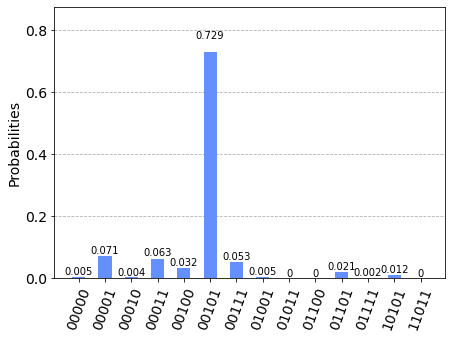

In [36]:
len(cal_circuits)
cal_job = execute(cal_circuits, backend = qcomp,shots = 1024, optimization_level = 3)
job_monitor(cal_job)
cal_results = cal_job.result()
plot_histogram(cal_results.get_counts(cal_circuits[5])
              )

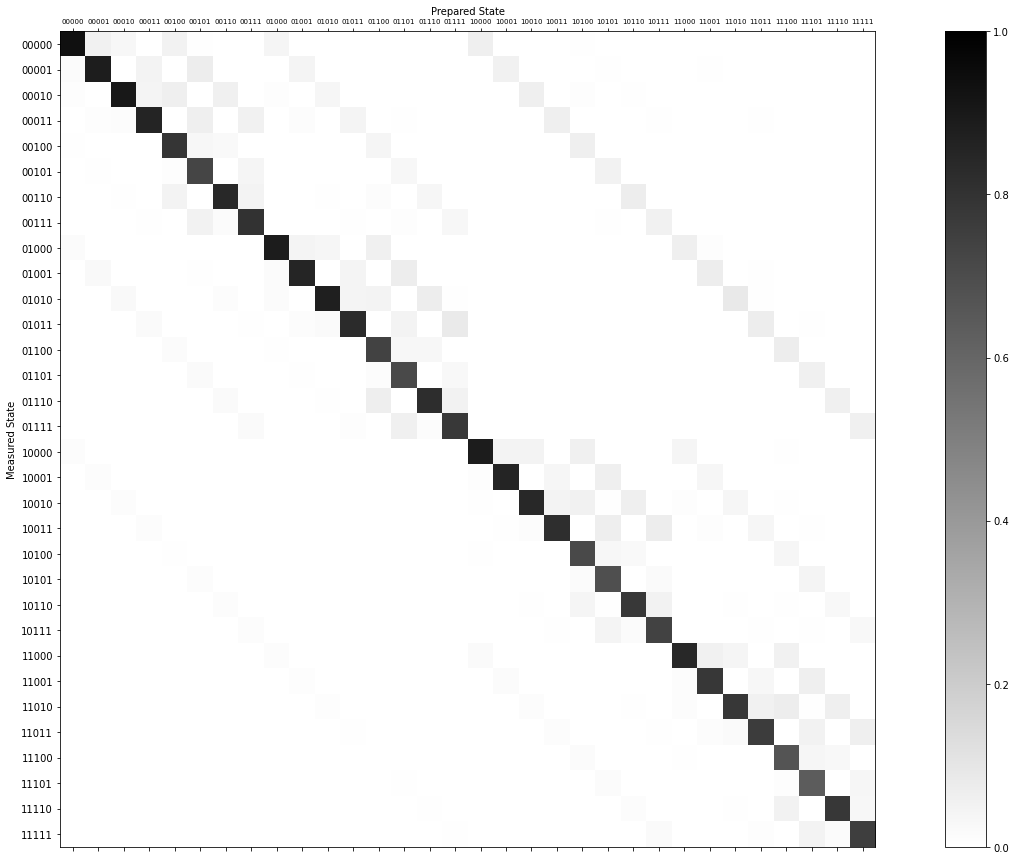

In [37]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=7) 
plt.rcParams["figure.figsize"] = (25,15)
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration(show_plot=True)

## Apply the filter to results from hardware

In [38]:
meas_filter = meas_fitter.filter

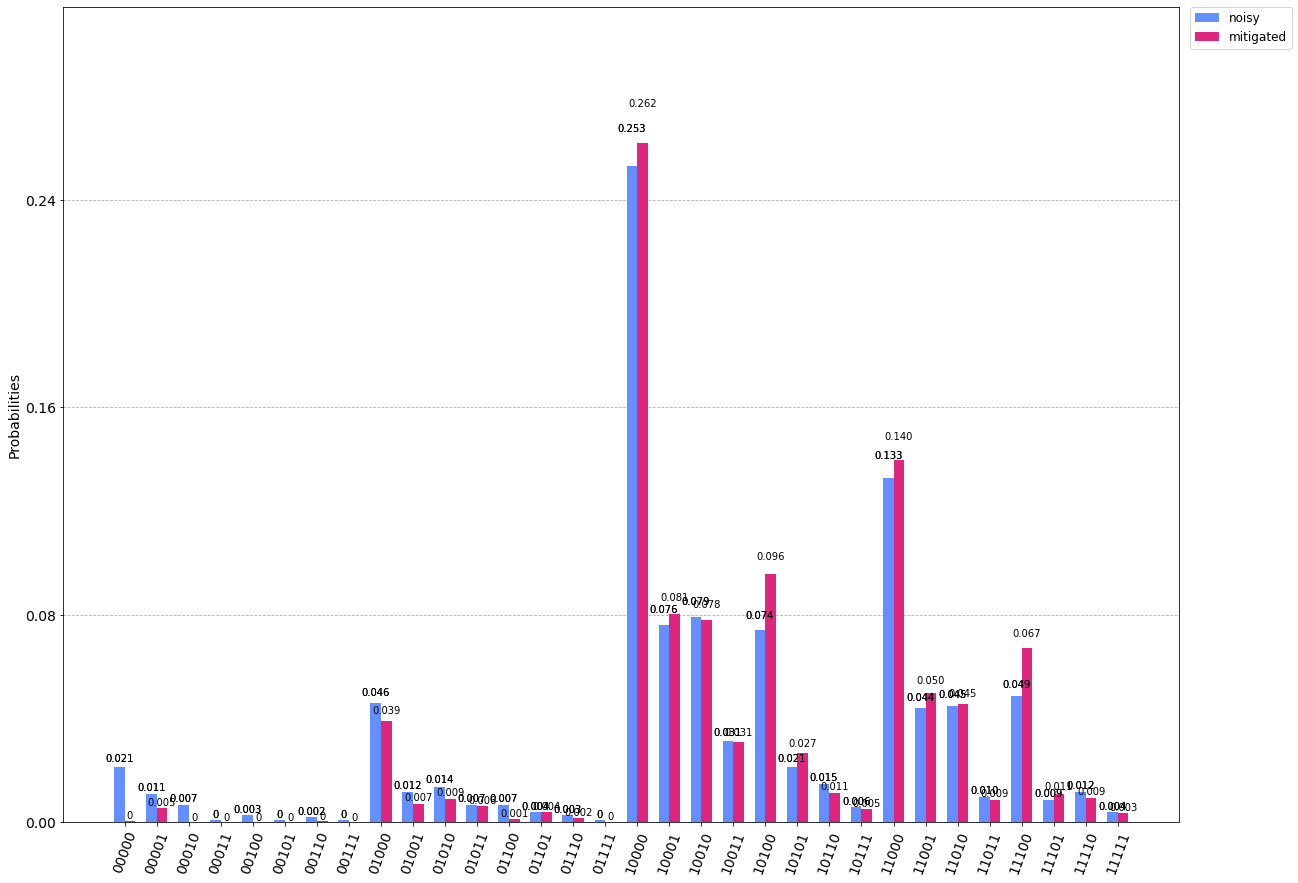

In [39]:
mitigated_results = meas_filter.apply(result)
device_counts = result.get_counts(circuit)
mitigated_counts = mitigated_results.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['noisy', 'mitigated'],figsize=(20,15))

In [42]:
meas_calibs, state_labels = complete_meas_cal(qr=q, circlabel='mcal')
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [43]:
noise_model = get_noise(0.1)
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.604 0.064 0.071 ... 0.    0.001 0.   ]
 [0.064 0.593 0.011 ... 0.    0.    0.   ]
 [0.062 0.008 0.575 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.592 0.007 0.071]
 [0.    0.    0.001 ... 0.006 0.594 0.057]
 [0.    0.001 0.001 ... 0.063 0.067 0.592]]


In [45]:
results = qiskit.execute(circuit, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'01011': 10, '01110': 53, '01001': 51, '00101': 9, '00000': 105, '10101': 98, '00100': 78, '00111': 4, '01000': 317, '10100': 613, '11111': 68, '11011': 102, '01101': 30, '01111': 11, '00010': 22, '11001': 473, '10110': 151, '10001': 175, '11110': 450, '10011': 38, '00110': 20, '01010': 59, '11100': 1692, '00011': 4, '11000': 2880, '10111': 24, '10000': 1018, '00001': 11, '10010': 244, '11010': 733, '01100': 209, '11101': 248}


In [46]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

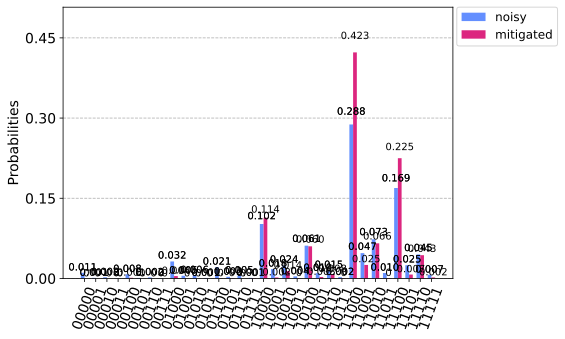

In [47]:
from qiskit.visualization import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])